# Predicting Late Return of Books

Questions asked are:
 
 - <b>build a model to predict the likelihood of a late return of any book at checkout time? </b>
 
  This notebook consists of data wrangling, data visualization and a model for predicting the possibility of a late return.

 - <b>Are there any factors you can find that are connected with late returns? </b>
 
  Yes. I find that distance between the library and the customer's residence is the most important factor in determining the possibility of a late return.
 The possibility of late return increases by increasing the distance between the library and the customer's residence.
 
 - <b>What would you recommend the library do to mitigate the risks you find? </b>
  
  I recommend the libraries prioritize renting books to the local customers, particularly those customers who live within 2-3 miles of the library. 
 
 - <b>How would you present your findings to them to get buy-in? </b>
 
On average 20% of the books return late in these libraries. If they can implement my recommendation of prioritizing local customers who live in nearby blocks it would reduce the late return to 10%. 
(since customers living within 3 miles have the probability of late returning of only 10%).   
 So, I would like to convince the Library that if this recommendation is considered it will reduce the late returns by half.

 ### Content of the Notebook:
- #### 1. Data Wrangling
- #### 2. Model Building
- #### 3. Visulaization and Conclusion

<b>NOTE :</b> It takes around 15-16 minutes for downloading the co-ordinate data. It will be saved in a file. In the next run, you are requested to comment out the "Get co-ordinates" block in the 'Standardizing customer data' section. 

----------

 For calculating the distance between the residence of the customers and the libraries we used the co-ordinate location of the addresses from 
 OpenStreetMap data source: https://www.openstreetmap.org/


## 1. Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import regex as re
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

import geopandas # package required to find coordinates from address (source: https://geopandas.org/en/stable/getting_started/install.html )
import geopy # package required to find coordinates from address (source: https://pypi.org/project/geopy/)

# These pacakges use data from OpenStreetMap data source: https://www.openstreetmap.org/

from geopy.geocoders import Nominatim

We import the given data sets in pandas dataframe:

In [2]:
book = pd.read_csv('data/books.csv')
checkout = pd.read_csv('data/checkouts.csv')
customer = pd.read_csv('data/customers.csv')
lib = pd.read_csv('data/libraries.csv')

#### Standardizing Books data 

The data tables contain some values which are distorted. We clear the data to make it workable. 

In [3]:
def get_price(x):
    m = re.search(r'[0-9]+\.[0-9]+', x)
    return float(m.group(0))

def get_number(x):
    m = re.search(r'[0-9]+', x)
    return int(m.group(0))

def get_author(x): #### filters uncessary space in the string
    auth_list = []
    for xi in x:
        if '  ' in xi:
            xi = ' '.join(x.split('  '))
        if '  ' in xi:
            xi = ' '.join(x.split('  '))
        if xi[0] == ' ' or xi[0] == "'" :
            xi = xi[1:]
        if xi[0] == ' ' or xi[0] == "'" :
            xi = xi[1:]
        if xi[-1] == ' ' or xi[-1] == "'":
            xi =xi[:-1]
        auth_list.append(xi)
    return auth_list

In [4]:
book_df= book.copy()
book_df['price'] = book['price'].fillna('0.0').apply(get_price)
book_df['categories'] = book['categories'].fillna("['Unknown']").apply(lambda x: x[2:-2].split(','))
book_df['authors'] = book['authors'].fillna("['Unknown']").apply(lambda x: x[2:-2].split(','))
book_df['authors'] = book_df.authors.apply(get_author)
book_df['pages'] = book['pages'].fillna(0).apply(get_number)
book_df['publisher'] = book['publisher'].fillna('Unknown') 
book_df['publishedDate'] = pd.to_datetime(book['publishedDate']).apply(lambda x: x.year)

#### Standardizing Customer data

Here we create two extra columns, customer's age and their coordinates of the residence address

In [5]:
customer_df = customer.copy()

def get_int(x):
    m = re.search(r'[0-9]+',x)
    return m.group(0)

def get_edu(x): 
    '''filters uncessary space in the string
    '''
    if '  ' in x:
        x = ' '.join(x.split('  '))
    if '  ' in x:
        x = ' '.join(x.split('  '))
    if x[0] == ' ':
        x = x[1:]
    if x[-1] == ' ':
        x =x[:-1]
    return x

def get_address(df): 
    '''
    Creates an address string from the information of street address, zipcode, city, state
    '''     
    add_list = []
    for i in range(len(df)):
        if df.zipcode[i] != '000':
            add = df.street_address[i] +', '+df.zipcode[i]
        elif df.city[i] == 'unknown' and df.state[i].lower() != 'unknown':
            add = df.street_address[i] +', '+df.state[i]
        else:
            add = df.street_address[i] +', '+df.state[i]
        add_list.append(add)
    return add_list

def get_coordinates(add): 
    '''
    Gets coordinates (latitude, longitude) of the corresponding address
    '''
    locator = Nominatim(user_agent="myGeocoder")
    location = locator.geocode(add)
    if location is not None:
        return location.latitude, location.longitude
    else:
        'unknown'

In [6]:
### Cleaning data and converting them in appropriate form
customer_df['zipcode'] = customer_df['zipcode'].fillna('000').apply(get_int)
customer_df['education'] = customer_df['education'].fillna('others').apply(lambda x: get_edu(x.lower()))
customer_df['gender'] = customer_df.gender.fillna('Unknown').apply(lambda x: get_edu(x.lower()))
customer_df['city'] = customer_df['city'].fillna('Unknown')
customer_df['state'] = customer_df['state'].fillna('Unknown')
customer_df['state'] = customer_df.state.apply(lambda x: get_edu(x.lower()))
customer_df['city'] = customer_df.city.apply(lambda x: get_edu(x.lower()))
customer_df['address'] = get_address(customer_df)
customer_df['address'] = customer_df['address'].apply(get_edu)
customer_df['birth_date'] = pd.to_datetime(customer_df['birth_date'])
customer_df['occupation'] = customer_df['occupation'].fillna('Unknown').apply(lambda x: get_edu(x.lower()))

## Calculate age of the customers
customer_df['age'] = (datetime.today().year - customer_df['birth_date'].apply(lambda x:x.year))

In [7]:
## Get co-ordinates
### This step takes around 15-16 minutes. It is advised that once it is done, save the results in a csv file and import that file later.
### This step collects the latitude and longitude from the address 

##### Please comment out the following part for next run.
cord_list = []
for i in range(len(customer_df)):    
    coord = get_coordinates(customer_df.address[i])
    cord_list.append(coord)
    
customer_df['coordiantes'] = cord_list   
customer_df['coordiantes'].to_csv('customer_loc.csv')

In [8]:
cord_list = pd.read_csv('customer_loc.csv')
customer_df['coordinates'] = cord_list['coordiantes']

#### Standardizing Checkout data

Here we create four extra columns weekday of check out (Sunday(0) to Saturday(6)), Month of the checkout, day of the month of the checkout, and late column which has value 1 if returned after 28 days, otherwise 0. 

In [9]:
### We drop all those entries where checkout date or return date is missing. 
### Since without one of this we cannot determine if the book was returned late. 
checkout_df = checkout.dropna().copy()

In [10]:
def get_date(x):
    '''
    finds date-like part from a string
    '''
    m = re.findall(r'[0-9]+', x)
    mj = ''.join(m)
    dd = str(mj[:4])+'-'+str(mj[4:6])+'-'+str(mj[-2:])
    return pd.to_datetime(dd)

In [11]:
checkout_df['date_checkout'] = checkout_df['date_checkout'].apply(get_date)
checkout_df['date_returned'] = checkout_df['date_returned'].apply(get_date)
checkout_df['duration'] = (checkout_df['date_returned'] - checkout_df['date_checkout']).apply(lambda x:x.days)
checkout_df = checkout_df[checkout_df['duration'] > 0 ]
checkout_df['late'] = checkout_df['duration'].apply(lambda x: 1 if x > 28 else 0)
checkout_df['weekday_checkout'] = checkout_df['date_checkout'].apply(lambda x: x.weekday())
checkout_df['day_checkout'] = checkout_df['date_checkout'].apply(lambda x: x.day)
checkout_df['month_checkout'] = checkout_df['date_checkout'].apply(lambda x: x.month)

#### Standardizing Library data
Here we create an extra column corresponding to the coordinates of the library address

In [12]:
lib_df = lib.copy()
lib_df['state'] = lib_df['region']
lib_df = lib_df.drop('region', axis = 1)
lib_df['zipcode'] = lib_df['postal_code']
lib_df = lib_df.drop('postal_code', axis = 1)
lib_df['zipcode'] = lib_df['zipcode'].fillna('000').apply(get_int)
lib_df['city'] = lib_df['city'].fillna('Unknown').apply(lambda x: get_edu(x.lower()))
lib_df['state'] = lib_df['state'].fillna('Unknown').apply(lambda x: get_edu(x.upper()))
lib_df['address'] = get_address(lib_df)

## This step may take few seconds
lib_df['lib_cord'] = lib_df['address'].apply(get_coordinates)

#### Next step

From here, we can either take a route to first visualize/analyse the possibility of late return against different variable, known as exploratory data analysis (EDA)

<b>OR</b> 

Build a model and from the model try to understand the effcet of diiferent features.

We take the second approach. It is because, if the data size and data features are too large, first approach might not work. 

## 2. Model Building

Let us combine the checkout data with customers, library and book. While joing, we drop some columns like checkout dates, name of customer, street_address of customer, street_address of library, customer's birthdate since all the information from that is already stored in other newly added features.

In [13]:
joined_df = checkout_df[['id','patron_id','library_id','weekday_checkout','day_checkout','month_checkout','late']].join(
    book_df.set_index('id'), on='id',how ='inner').join(
    customer_df.set_index('id'), on='patron_id',how ='inner').join(
    lib_df.set_index('id'), on='library_id',how ='inner', lsuffix = '_cust', rsuffix = '_lib')

In [14]:
joined_df = joined_df.drop(['birth_date','name_cust','street_address_cust','street_address_lib', 'address_cust', 'address_lib'],axis=1)

joined_df = joined_df[~joined_df['coordinates'].isnull()].reset_index()

In [15]:
def get_distance(cord1, cord2):
    '''
    This function calculate the geographical distance bewteen two points on the surface of earth
    '''
    cord1 = cord1[1:-1].split(', ')
    #cord2 = cord2[1:-1].split(', ')
    lon1 = np.radians(float(cord1[1]))
    lon2 = np.radians(float(cord2[1]))
    lat1 = np.radians(float(cord1[0]))
    lat2 = np.radians(float(cord2[0]))
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2 
    c = 2 * np.arcsin(np.sqrt(a))   
    # Radius of earth in miles
    r = 3956
    return(c * r)

In [16]:
dist_list = [get_distance(joined_df['coordinates'][i], joined_df['lib_cord'][i]) for i in range(len(joined_df))]
joined_df['distance'] = dist_list
joined_df = joined_df.drop(['coordinates','lib_cord','index'],axis=1)

joined_df = joined_df[joined_df['age'] > 0 ] ## Filter's out wrongly provided date of birth
joined_df = joined_df[joined_df['distance'] < 100 ] ### Filters out one wrongly calculated distance
joined_df = joined_df.dropna() ## Finally droping all NaN values

### Choice of model

Since our independent variables are in continuous( age, price, page, distance) and discrete (book-id, author, category etc.) form and our dependent varible 'late' is completely discreet (0 or 1) we need a 'classifier' like DecisionTree/RandomForest, K-NN etc. Logistic regression is not suitable since some of the independent variables are discrete. SVM will be computationally too expensive for so many features. 

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [18]:
## Transform the data to a suitable form 

transformer = FeatureUnion([
                ('rest_of_all', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x[['distance','id', 'patron_id', 'library_id',
                                                               'publisher', 'publishedDate', 'price', 'pages',
                                                               'weekday_checkout','day_checkout','month_checkout',
                                                               'state_cust', 'zipcode_cust','city_cust',
                                                              'gender', 'education', 'occupation','age',
                                                               'city_lib','state_lib', 'zipcode_lib']].T.to_dict().values(),           
                                                  validate=False)),
                            ('dictvec', 
                              DictVectorizer())])),
                ('author', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['authors'], 
                                                  validate=False)),
                            ('countvec', 
                              CountVectorizer(tokenizer=lambda doc: doc,lowercase=False))])),
                ('category', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['categories'], 
                                                  validate=False)),
                            ('countvec', 
                              CountVectorizer(tokenizer=lambda doc: doc,lowercase=False))]))])

In [19]:
X = transformer.fit_transform(joined_df)
y = np.array(joined_df['late'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # Keeping 30% of data in test

In [20]:
# RandomForestClassifier
## Performing grid_search Cross-Validation to find suitable hyper-parameeters 
parameters = {'max_depth':np.arange(2,50),'random_state':[1]}
tree = RandomForestClassifier()
clf = GridSearchCV(tree, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'random_state': [1]})

In [21]:
clf.best_params_

{'max_depth': 47, 'random_state': 1}

In [22]:
clf.score(X_test,y_test)

0.8521939953810623

In [23]:
## KNeighborsClassifier
## Performing grid_search Cross-Validation to find suitable hyper-parameeters 
parameters = {'n_neighbors': np.arange(3,25)}
knn = KNeighborsClassifier()
kclf = GridSearchCV(knn, parameters)
kclf.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24])})

In [24]:
kclf.best_params_

{'n_neighbors': 21}

In [25]:
kclf.score(X_test,y_test)

0.836027713625866

#### So, RandomForestClassifier works little bit better than K-NN

#### Now, let us find which feature is mainly determing the outcome

Let us construct another copy of the  RandomForestClassifier model with best params for Feature extarction

In [26]:
rfc = RandomForestClassifier(max_depth=47,random_state=1)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=47, random_state=1)

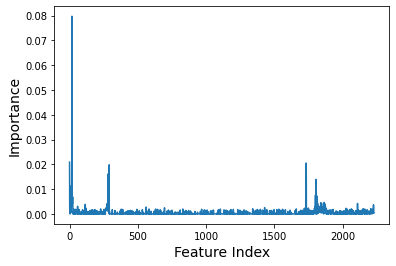

In [27]:
plt.plot(rfc.feature_importances_)
plt.xlabel('Feature Index', fontsize = '14')
plt.ylabel('Importance',fontsize = '14');

We can see that only some of the features are very important. Others are not. Let us find what are these features.

In [28]:
imp_list = [i for i, imp in enumerate(rfc.feature_importances_) if imp > 0.01] # We set a cutoff of 0.01 looking the plot above

In [29]:
imp_list

[0, 9, 16, 17, 281, 290, 1732, 1733, 1803]

In [30]:
## It is not possible to extract the Featurenames directly from the 'transformer' FeatureUnion. 
## So we collect the feature names from the first step of DictVectorization() 

In [31]:
vec1 = DictVectorizer()
vec1.fit_transform(joined_df[['distance','id', 'patron_id', 'library_id',
                                                               'publisher', 'publishedDate', 'price', 'pages',
                                                               'weekday_checkout','day_checkout','month_checkout',
                                                               'state_cust', 'zipcode_cust','city_cust',
                                                              'gender', 'education', 'occupation','age',
                                                               'city_lib','state_lib', 'zipcode_lib']].T.to_dict().values())

<1441x1877 sparse matrix of type '<class 'numpy.float64'>'
	with 30261 stored elements in Compressed Sparse Row format>

In [32]:
### len(vec1.get_feature_names()) = 1877 suggest that all the important features are already in the this list. Author and Category is not important.
[vec1.get_feature_names()[i] for i in imp_list]

['age',
 'city_cust=portland',
 'day_checkout',
 'distance',
 'month_checkout',
 'pages',
 'price',
 'publishedDate',
 'weekday_checkout']

#### Most important feature

In [33]:
np.argmax(rfc.feature_importances_)

17

In [34]:
vec1.get_feature_names()[17]

'distance'

#### So, distance between the Library and the Customer's residence is the most important determining factor for Late Return

Therefore, we can make an even simplier model with fewer features with works almost eqally well.

In [35]:
imp_list2 = [i for i, imp in enumerate(rfc.feature_importances_) if imp > 0.02]
[vec1.get_feature_names()[i] for i in imp_list2]

['age', 'day_checkout', 'distance', 'price']

In [36]:
X = joined_df[['age', 'day_checkout', 'distance', 'price']]
y = joined_df['late']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # Keeping 30% of data in test

In [37]:
# RandomForestClassifier
## Performing grid_search Cross-Validation to find suitable hyper-parameeters 
parameters = {'max_depth':np.arange(2,50),'random_state':[1]}
tree = RandomForestClassifier()
clf = GridSearchCV(tree, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'random_state': [1]})

In [38]:
clf.best_params_

{'max_depth': 3, 'random_state': 1}

In [39]:
clf.score(X_test,y_test)

0.8383371824480369

## 3. Visualization and Conclusion

We plot probability of late return with different parameters from the data to check if the model's prediction is consistent with the data. We start with top 4 parameters: Distance, Age of the Customer, Price of the book, Day of the month for checkout. 

In [40]:
bin_df = joined_df[['late']].copy()
bin_df['dist_bin'] = joined_df['distance'].apply(lambda x: (x//1)+1)
bin_df['price_bin'] = joined_df['price'].apply(lambda x: x//50)
bin_df['page_bin'] = joined_df['pages'].apply(lambda x: x//100)
bin_df['age_bin'] = joined_df['age'].apply(lambda x: x//10)

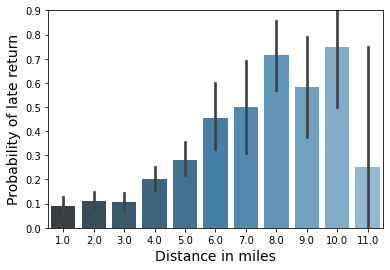

In [41]:
sns.barplot(data=bin_df, x = 'dist_bin', y='late', palette="Blues_d")
plt.xlabel('Distance in miles', fontsize=14)
plt.ylabel('Probability of late return', fontsize=14)
plt.xlim(-0.5,10.5)
plt.ylim(0,0.9)
#plt.grid('on')
plt.savefig('dist.png', dpi = 200)

''

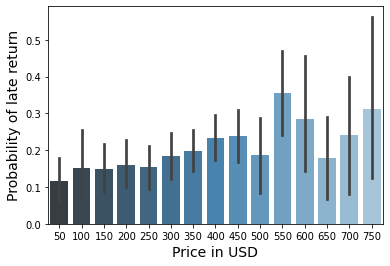

In [42]:
fig, ax = plt.subplots()
sns.barplot(data=bin_df, x = 'price_bin', y='late',palette="Blues_d")
ax.set_xticklabels([50*i for i in range(1,16)])
plt.xlabel('Price in USD', fontsize=14)
plt.ylabel('Probability of late return', fontsize=14)
#plt.grid('on')
plt.savefig('price.png', dpi = 200)
;

''

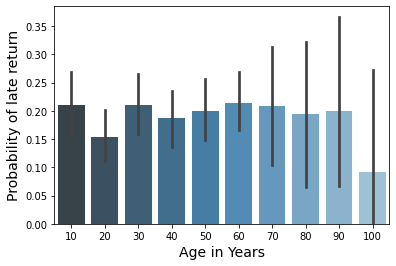

In [43]:
fig, ax = plt.subplots()
sns.barplot(data=bin_df, x = 'age_bin', y='late',palette="Blues_d")
ax.set_xticklabels([10*i for i in range(1,11)])
plt.xlabel('Age in Years', fontsize=14)
plt.ylabel('Probability of late return', fontsize=14)
#plt.grid('on')
plt.savefig('age.png', dpi = 200)
;

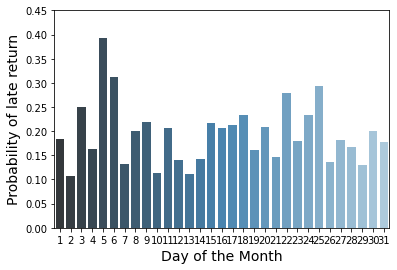

In [44]:
sns.barplot(data=joined_df, x = 'day_checkout', y='late', palette="Blues_d", ci=None)
plt.xlabel('Day of the Month', fontsize=14)
plt.ylabel('Probability of late return', fontsize=14)
#plt.xlim(-0.5,10.5)
plt.ylim(0,0.45)
#plt.grid('on')
plt.savefig('day_of_month.png', dpi = 200)

#### Let's see other unimportant factors predicted by the model

''

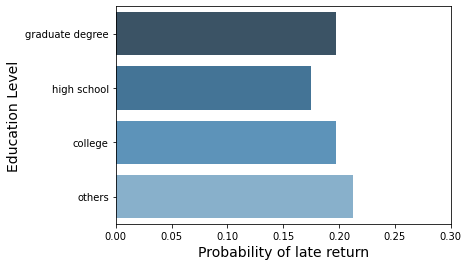

In [45]:
sns.barplot(data=joined_df, y = 'education', x='late', orient= 'h',palette="Blues_d", ci=None);
plt.xlim(0,0.30)
plt.ylabel('Education Level', fontsize=14)
plt.xlabel('Probability of late return', fontsize=14)
;

''

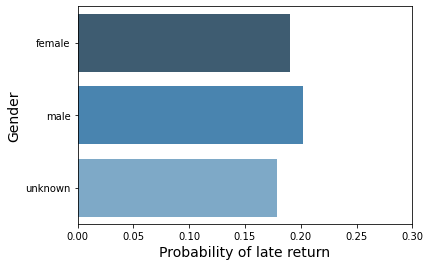

In [46]:
sns.barplot(data=joined_df, y = 'gender', x='late', orient= 'h',palette="Blues_d", ci=None);
plt.xlim(0,0.30)
plt.ylabel('Gender', fontsize=14)
plt.xlabel('Probability of late return', fontsize=14)
;

### Conclusion

- The distance between the Customer's residence and the Library is the most important factor. For the distance within 3 miles, the possibility of late return is around 10%, whereas for distance > 8 miles the possibility is 70-80%.
- Other factors like days of the month seem to play some role, where the possibility of late return is high if the book is checked out on earlier days of the month. However, the effect of this is less important than distance. 
- Similarly price of the book or age has some importance, but their importance is not sufficient enough that one can predict a late return depending on these factors.
- Education level, gender of the customer, publisher or author of the book has practically no effect on a late return. 

#### Depending on these, I recommend the libraries prioritize renting books to the local customers, particularly those customers which live within 3 miles of the library.

-------------------
Arindam Mazumdar (arindam.presi@gmail.com)